<a href="https://colab.research.google.com/github/remisoulignac/scm_optim_problems/blob/main/SCM290_Week4_TourSustainable_Consolidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ortools

# Problem
Every day (i.e. every round), the company has incoming and expected orders for the whole planning horizon (see Delivery Map and Table for more details). Based on this information, you are to choose every day to either deliver an order or postpone it. Every day that you make a decision, the company will receive new incoming orders and also defined new expected orders for the following days. 

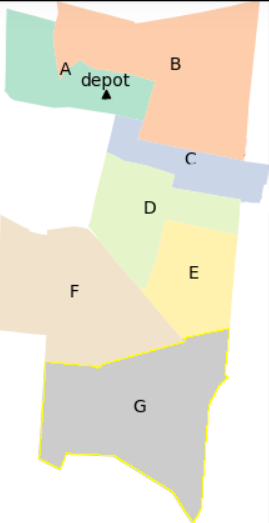

Measures done with https://imagej.nih.gov/

| R | AREA | Centroid X | Centroid Y |
| --- | --- | --- | --- |
| 1 | 5042 | 53.089 | 59.872 |
| 2 | 12377 | 141.495 | 55.948 |
| 3 | 3491 | 153.188 | 132.065 |
| 4 | 5983 | 120.959 | 170.961 |
| 5 | 5068 | 156.296 | 222.992 |
| 6 | 10909 | 60.950 | 238.262 |
| 7 | 13206 | 112.610 | 329.386 |


# Solution Approach
At each period, we have an estimation of the number of delivery points that we have to deliver  on next periods on each Region (A, B, c...) . We don't know exactly where the demand will occur so have to rely on an estimation of the hauling and local routing distance for n stops. For that, we use the classical formula
$$ D = 2 \times d_{LineHaul} + k_{TSP}\sqrt{n_{stops} \times Area} $$

with $$k_{TSP} = 0.765$$being the Traveling Salesman Problem network factor. This value is commonly used for euclidean networks (not grid) and considered a good approximation.

This formula is an approximation for "fairly compact and fairly convex" areas. It is not really the case for regions B, D, A but we wil assume this approximation is sufficient.

We compute the routes from the depot to these regions and for various number of demand stops. We also compute the routes for 2 adjacent regions (A+B, B+C, ...). Each route is defined by the covered Regions, the number of stop, and the total distance.

We then define a classical mixed integer linear programming model with decision variables to define 

- whether a route is activated for each period
- whether a request

So as to minimize the CO2 emission, we will try to fill the trucks at least at 90% of their capacity.

The objective is to minimize the total distance of the activated routes.

# Advantage and limits
The model is applicable at different times and in different places. It can be challenged and improved based on actual measurements. It helps raise other questions such as: what is the network factor of each delivery area? how to forecast the demand for the next N periods? Are the delivery zones well defined?  Is each type of truck well suited to each delivery zone? ...

Limits : 

- This model will always ensure 100% On Time Delivery, whatever the CO2 emission cost
- Even when known, the model does not account for the actual location of each demand node. This raises questionable decisions such as in period 6 where 2 demand nodes in region B, diametrically opposed to each other, are served during the same tour.

In [36]:
from ortools.sat.python import cp_model
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

INFINITY = cp_model.INT32_MAX
model = cp_model.CpModel()

#helper functions to deal with arrays
add_constraints_eq=np.vectorize(lambda e,c : model.Add(e==c))
add_constraints_ge=np.vectorize(lambda e,c : model.Add(e>=c))
add_constraints_le=np.vectorize(lambda e,c : model.Add(e<=c))
vararray_to_resultarray=np.vectorize(lambda v:solver.Value(v))
vararray_to_results=np.vectorize(lambda v:f'{v.Name()}={solver.Value(v)}')


# Region, Area (pixel^2), X, Y
Depot=(86, 77)

Regions = {
  'A': [5042,  ['A'],  (53.089, 59.872)],
  'B': [12377, ['B'], (141.495, 55.948)],
  'C': [3491,  ['C'], (153.188,	132.065)],
  'D': [5983,	 ['D'], (120.959,	170.961)],
  'E': [5068,	 ['E'], (156.296,	222.992)],
  'F': [10909, ['F'],	(60.950,	238.262)],
  'G': [13206, ['G'],	(112.610,	329.386)]
}

#multiregions (we compute the barycenter)
for mr in [['A','B'],['B','C'],['C','D'], ['D','E'], ['E','F'], ['F','G']  ]:
  v=Regions[mr[0]]
  w=Regions[mr[1]]
  Regions[mr[0]+mr[1]]=[v[0]+w[0], mr, ((v[2][0]*v[0]+w[2][0]*w[0])/(v[0]+w[0]), (v[2][1]*v[0]+w[2][1]*w[0])/(v[0]+w[0]))  ]
# for mr in [['A','B','C'],['C','D','E'],['D','E','F'], ['E','F','G'] ]:
#   u=Regions[mr[0]]
#   v=Regions[mr[1]]
#   w=Regions[mr[2]]
#   Regions[mr[0]+mr[1]+mr[2]]=[
#       u[0]+v[0]+w[0],
#       mr, 
#       (
#         (u[2][0]*u[0]+v[2][0]*v[0]+w[2][0]*w[0])/(u[0]+v[0]+w[0]),
#         (u[2][1]*u[0]+v[2][1]*v[0]+w[2][1]*w[0])/(u[0]+v[0]+w[0])
#       )  ]


def EstimateDeliveryDistance(region_name, num_stops):
  line_haul = math.dist(Depot, Regions[region_name][2])
  kTSP=0.765 # commonly used
  local_routing=kTSP*math.sqrt(num_stops*Regions[region_name][0])
  return int((2*line_haul+local_routing)*10)

#-- INPUTS
#(Name, Cost]
min_stop_per_region=2
max_stop_per_region=8

# RouteName,Regions,NumStops,Distance
Routes= [(f'{r}{num_stops}',Regions[r][1], num_stops, EstimateDeliveryDistance(r,num_stops)) for r in Regions.keys() for num_stops in range(min_stop_per_region, max_stop_per_region+1)]

NumberOfPeriods=13
TruckCapacity=10

#[Order Number,	Order Date (1-based period),	Delivered By (1-based period),	Zip Code,	Quantity]
DemandNodes=[
  (1, 1, 4, 'C', 4),
  (2, 1, 3, 'C', 5),
  (3, 1, 6, 'B', 5),
  (4, 1, 5, 'A', 3),
  (5, 1, 4, 'A', 1),
  (6, 1, 3, 'A', 1),
  (7, 2, 5, 'A', 5),
  (8, 2, 7, 'C', 5),
  (9, 2, 7, 'C', 4),
  (10, 2, 4, 'C', 3),
  (11, 2, 5, 'A', 5),
  (12, 2, 4, 'B', 4),
  (13, 2, 3, 'B', 4),
  (14, 2, 5, 'B', 2),
  (15, 2, 5, 'B', 3),
  (16, 2, 8, 'D', 3),
  (17, 2, 6, 'B', 4),
  (18, 2, 7, 'C', 2),
  (19, 3, 5, 'B', 4),
  (20, 3, 4, 'A', 2),
  (21, 3, 9, 'D', 3),
  (22, 4, 8, 'B', 2),
  (23, 4, 6, 'B', 2),
  (24, 4, 7, 'B', 3),
  (25, 5, 10, 'A', 3),
  (26, 5, 6, 'C', 2),
  (27, 5, 7, 'B', 5),
  (28, 5, 11, 'C', 3),
  (29, 5, 10, 'B', 3),
  (30, 5, 6, 'D', 1),
  (31, 5, 8, 'B', 5),
  (32, 5, 10, 'B', 4),
  (33, 5, 11, 'B', 3),
  (34, 5, 11, 'A', 3),
  (35, 5, 8, 'B', 4),
  (36, 5, 8, 'A', 1),
  (37, 6, 7, 'A', 4),
  (38, 6, 9, 'D', 5),
  (39, 6, 9, 'C', 2),
  (40, 6, 7, 'A', 5),
  (41, 6, 7, 'B', 5),
  (42, 6, 8, 'B', 1),
  (43, 6, 7, 'D', 3),
  (44, 7, 8, 'A', 2),
  (45, 7, 11, 'D', 5),
  (46, 7, 11, 'C', 3),
  (47, 7, 13, 'B', 5),
  (48, 7, 8, 'D', 3),
  (49, 7, 9, 'B', 5),
  (50, 7, 9, 'B', 3),
  (51, 7, 10, 'B', 5),
  (52, 7, 10, 'C', 1),
  (53, 7, 11, 'D', 5),
  (54, 7, 11, 'D', 2),
  (55, 7, 9, 'C', 1),
  (56, 7, 13, 'B', 4),
  (57, 7, 11, 'C', 2),
  (58, 7, 8, 'C', 5),
  (59, 8, 10, 'C', 4),
  (60, 8, 13, 'B', 1),
  (61, 8, 11, 'A', 3),
  (62, 8, 13, 'A', 3),
  (63, 8, 13, 'B', 4),
  (64, 8, 10, 'D', 4),
  (65, 8, 10, 'C', 5),
  (66, 8, 12, 'C', 4),
  (67, 8, 10, 'D', 4),
  (68, 8, 11, 'C', 2),
  (69, 8, 9, 'C', 5),
  (70, 8, 13, 'A', 2),
  (71, 8, 12, 'D', 4),
  (72, 8, 13, 'C', 3),
  (73, 8, 9, 'A', 5),
  (74, 8, 12, 'C', 4),
  (75, 9, 10, 'G', 1),
  (76, 9, 10, 'F', 2),
  (77, 9, 10, 'F', 2),
  (78, 9, 11, 'E', 1),
  (79, 9, 11, 'F', 4),
  (80, 9, 10, 'G', 3),
  (81, 9, 12, 'F', 4),
  (82, 9, 13, 'G', 4),
  (83, 10, 11, 'F', 4),
  (84, 10, 13, 'G', 5),
  (85, 10, 13, 'F', 1),
  (86, 11, 12, 'G', 3),
  (87, 11, 12, 'F', 3),
  (88, 11, 13, 'E', 5),
  (89, 11, 13, 'G', 1),
  (90, 11, 11, 'E', 5),
  (91, 11, 13, 'E', 2),
  (92, 11, 13, 'F', 1),
  (93, 11, 12, 'E', 1),
  (94, 11, 13, 'G', 1),
  (95, 11, 12, 'F', 3),
  (96, 11, 11, 'F', 3),
  (97, 11, 13, 'G', 2),
  (98, 11, 13, 'G', 5),
  (99, 11, 13, 'E', 5),
  (100, 11, 13, 'E', 4),
  (101, 11, 13, 'G', 4),
  (102, 11, 13, 'E', 3),
  (103, 11, 11, 'F', 3),
  (104, 11, 13, 'E', 4),
  (105, 11, 13, 'F', 1),
  (106, 11, 12, 'E', 4),
  (107, 11, 13, 'G', 4),
  (108, 11, 13, 'E', 2),
  (109, 11, 11, 'E', 2),
  (110, 11, 13, 'F', 3),
  (111, 11, 11, 'E', 3),
  (112, 11, 13, 'G', 4),
  (113, 11, 13, 'G', 5),
  (114, 11, 13, 'F', 5),
  (115, 11, 13, 'F', 3),
  (116, 12, 13, 'E', 4),
  (117, 12, 13, 'E', 2),
  (118, 13, 13, 'F', 5),
  (119, 13, 13, 'E', 2),
  (120, 13, 13, 'E', 2)
]

# DECISION VARIABLES
#Period x #Routes
PeriodXRouteDV=np.asarray(list(list(model.NewIntVar(0,2, f"Period:{p},Route:{r[0]}") for r in Routes) for p in range(1, NumberOfPeriods+1)))

# DemandNode x Period x Route
DemandNodeXPeriodXRouteDV=np.asarray(list(list(list(
    model.NewBoolVar(f"Order:{dn[0]}[Q={dn[4]}],Region:{dn[3]},Period:{p}[{dn[1]},{dn[2]}],Route:{r[0]}") if dn[3] in r[1] and p in range(dn[1], dn[2]+1) else 0  
    for r in Routes ) # only decision variable for route matching the node's region
    for p in range(1,NumberOfPeriods+1)) # from start to end period
    for dn in DemandNodes),dtype=object)

# CONSTRAINTS
# must have  one and only one selected route per demandnode
for pr in DemandNodeXPeriodXRouteDV:
  add_constraints_eq(np.sum(pr), 1)

# maximum number of demand nodes served and maximum capacity served per period and region depend on the activated routes
for p in range(NumberOfPeriods):
  for ri in range(len(Routes)):
    # only the nodes for which we have yet identified a decision variable for this period and route
    idxDn=[i for i in range(len(DemandNodeXPeriodXRouteDV)) if isinstance(DemandNodeXPeriodXRouteDV[i, p, ri], cp_model.IntVar) ]
    dvDnRoutes=DemandNodeXPeriodXRouteDV[idxDn,p,ri]
    if (len(dvDnRoutes)>0):
      routeNumStops=Routes[ri][2]
      dnQuantities=np.transpose(np.asarray([DemandNodes[i][4] for i in idxDn]))
      # the number of served node <= route_num_stops
      model.Add(np.sum(dvDnRoutes)==PeriodXRouteDV[p, ri]*routeNumStops)
      # truck should be full at least 92%
      model.Add(np.sum(dvDnRoutes*dnQuantities*100)>=PeriodXRouteDV[p, ri]*TruckCapacity*90)
      # cannot overload the truck
      model.Add(np.sum(dvDnRoutes*dnQuantities)<=PeriodXRouteDV[p, ri]*TruckCapacity)

routeDistances=np.asarray([Routes[i][3] for i in range(len(Routes))])
Objective=np.sum(PeriodXRouteDV*routeDistances)

model.Minimize(Objective)

print(model.ModelStats())
#-- EXECUTION
solver = cp_model.CpSolver()
solver.parameters.log_search_progress = True
solver.log_callback = print  # (str)->None
solver.parameters.max_time_in_seconds = 1800 

status = solver.Solve(model)
print(status)
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
   print("Objective=", solver.ObjectiveValue())
   for p in range(NumberOfPeriods):
     for r in range(len(Routes)):
       pr=PeriodXRouteDV[p,r]
       s=solver.Value(pr)
       if s>0:
         print(f'{pr}:{s}')
     for dn in range(len(DemandNodes)):
       for r in range(len(Routes)):
         dv=DemandNodeXPeriodXRouteDV[dn,p,r]
         if solver.Value(dv)==1:
           print(dv)


optimization model '': (model_fingerprint: 0x17f955ab0e9f41c4)
#Variables: 9415 (#ints:1183 in objective)
  - 8232 Booleans in [0,1]
  - 1183 in [0,2]
#kLinear2: 168
#kLinear3: 168
#kLinearN: 2550 (#terms: 42966)

Starting CP-SAT solver v9.5.2237
Parameters: max_time_in_seconds: 1800 log_search_progress: true
Setting number of workers to 2

Initial optimization model '': (model_fingerprint: 0x17f955ab0e9f41c4)
#Variables: 9415 (#ints:1183 in objective)
  - 8232 Booleans in [0,1]
  - 1183 in [0,2]
#kLinear2: 168
#kLinear3: 168
#kLinearN: 2550 (#terms: 42966)

Starting presolve at 0.02s
[ExtractEncodingFromLinear] #potential_supersets=240 #potential_subsets=0 #at_most_one_encodings=0 #exactly_one_encodings=0 #unique_terms=0 #multiple_terms=0 #literals=0 time=0.000466238s
[Probing] deterministic_time: 0.0808556 (limit: 1) wall_time: 0.235701 (7718/7718)
[Probing]  - new fixed Boolean: 350 (1675/9043)
[Probing]  - new binary clause: 1916
[Probing] implications and bool_or (work_done=73627)

```
Objective= 137333.0
Period:3,Route:A4:1
Period:3,Route:C3:1
Period:3,Route:AB3:1
Order:2[Q=5],Region:C,Period:3[1,3],Route:C3
Order:5[Q=1],Region:A,Period:3[1,4],Route:A4
Order:6[Q=1],Region:A,Period:3[1,3],Route:A4
Order:10[Q=3],Region:C,Period:3[2,4],Route:C3
Order:11[Q=5],Region:A,Period:3[2,5],Route:A4
Order:13[Q=4],Region:B,Period:3[2,3],Route:AB3
Order:14[Q=2],Region:B,Period:3[2,5],Route:AB3
Order:18[Q=2],Region:C,Period:3[2,7],Route:C3
Order:19[Q=4],Region:B,Period:3[3,5],Route:AB3
Order:20[Q=2],Region:A,Period:3[3,4],Route:A4
Period:4,Route:C2:1
Period:4,Route:AB3:1
Order:1[Q=4],Region:C,Period:4[1,4],Route:C2
Order:8[Q=5],Region:C,Period:4[2,7],Route:C2
Order:12[Q=4],Region:B,Period:4[2,4],Route:AB3
Order:15[Q=3],Region:B,Period:4[2,5],Route:AB3
Order:24[Q=3],Region:B,Period:4[4,7],Route:AB3
Period:5,Route:A4:1
Period:5,Route:AB2:1
Period:5,Route:AB3:1
Order:4[Q=3],Region:A,Period:5[1,5],Route:A4
Order:7[Q=5],Region:A,Period:5[2,5],Route:AB2
Order:17[Q=4],Region:B,Period:5[2,6],Route:AB3
Order:23[Q=2],Region:B,Period:5[4,6],Route:AB3
Order:25[Q=3],Region:A,Period:5[5,10],Route:A4
Order:32[Q=4],Region:B,Period:5[5,10],Route:AB3
Order:34[Q=3],Region:A,Period:5[5,11],Route:A4
Order:35[Q=4],Region:B,Period:5[5,8],Route:AB2
Order:36[Q=1],Region:A,Period:5[5,8],Route:A4
Period:6,Route:C3:1
Period:6,Route:D4:1
Period:6,Route:AB2:1
Order:3[Q=5],Region:B,Period:6[1,6],Route:AB2
Order:9[Q=4],Region:C,Period:6[2,7],Route:C3
Order:16[Q=3],Region:D,Period:6[2,8],Route:D4
Order:21[Q=3],Region:D,Period:6[3,9],Route:D4
Order:26[Q=2],Region:C,Period:6[5,6],Route:C3
Order:28[Q=3],Region:C,Period:6[5,11],Route:C3
Order:30[Q=1],Region:D,Period:6[5,6],Route:D4
Order:41[Q=5],Region:B,Period:6[6,7],Route:AB2
Order:43[Q=3],Region:D,Period:6[6,7],Route:D4
Period:7,Route:A2:1
Period:7,Route:AB2:1
Order:27[Q=5],Region:B,Period:7[5,7],Route:AB2
Order:37[Q=4],Region:A,Period:7[6,7],Route:A2
Order:40[Q=5],Region:A,Period:7[6,7],Route:A2
Order:56[Q=4],Region:B,Period:7[7,13],Route:AB2
Period:8,Route:A4:1
Period:8,Route:D2:1
Period:8,Route:D3:1
Period:8,Route:AB2:2
Period:8,Route:AB5:1
Period:8,Route:BC2:1
Order:22[Q=2],Region:B,Period:8[4,8],Route:AB5
Order:29[Q=3],Region:B,Period:8[5,10],Route:AB5
Order:31[Q=5],Region:B,Period:8[5,8],Route:BC2
Order:33[Q=3],Region:B,Period:8[5,11],Route:AB2
Order:38[Q=5],Region:D,Period:8[6,9],Route:D2
Order:42[Q=1],Region:B,Period:8[6,8],Route:AB5
Order:44[Q=2],Region:A,Period:8[7,8],Route:A4
Order:48[Q=3],Region:D,Period:8[7,8],Route:D3
Order:49[Q=5],Region:B,Period:8[7,9],Route:AB2
Order:50[Q=3],Region:B,Period:8[7,9],Route:AB5
Order:51[Q=5],Region:B,Period:8[7,10],Route:AB2
Order:54[Q=2],Region:D,Period:8[7,11],Route:D3
Order:58[Q=5],Region:C,Period:8[7,8],Route:BC2
Order:60[Q=1],Region:B,Period:8[8,13],Route:AB5
Order:61[Q=3],Region:A,Period:8[8,11],Route:A4
Order:62[Q=3],Region:A,Period:8[8,13],Route:A4
Order:64[Q=4],Region:D,Period:8[8,10],Route:D2
Order:67[Q=4],Region:D,Period:8[8,10],Route:D3
Order:70[Q=2],Region:A,Period:8[8,13],Route:A4
Order:73[Q=5],Region:A,Period:8[8,9],Route:AB2
Period:9,Route:C2:1
Period:9,Route:C5:1
Order:39[Q=2],Region:C,Period:9[6,9],Route:C5
Order:52[Q=1],Region:C,Period:9[7,10],Route:C5
Order:55[Q=1],Region:C,Period:9[7,9],Route:C5
Order:59[Q=4],Region:C,Period:9[8,10],Route:C5
Order:65[Q=5],Region:C,Period:9[8,10],Route:C2
Order:68[Q=2],Region:C,Period:9[8,11],Route:C5
Order:69[Q=5],Region:C,Period:9[8,9],Route:C2
Period:10,Route:FG5:1
Order:75[Q=1],Region:G,Period:10[9,10],Route:FG5
Order:76[Q=2],Region:F,Period:10[9,10],Route:FG5
Order:77[Q=2],Region:F,Period:10[9,10],Route:FG5
Order:80[Q=3],Region:G,Period:10[9,10],Route:FG5
Order:85[Q=1],Region:F,Period:10[10,13],Route:FG5
Period:11,Route:C3:1
Period:11,Route:D2:1
Period:11,Route:F2:1
Period:11,Route:F3:2
Period:11,Route:CD3:1
Period:11,Route:DE2:1
Period:11,Route:DE5:1
Order:45[Q=5],Region:D,Period:11[7,11],Route:D2
Order:46[Q=3],Region:C,Period:11[7,11],Route:C3
Order:53[Q=5],Region:D,Period:11[7,11],Route:D2
Order:57[Q=2],Region:C,Period:11[7,11],Route:CD3
Order:66[Q=4],Region:C,Period:11[8,12],Route:CD3
Order:71[Q=4],Region:D,Period:11[8,12],Route:CD3
Order:72[Q=3],Region:C,Period:11[8,13],Route:C3
Order:74[Q=4],Region:C,Period:11[8,12],Route:C3
Order:78[Q=1],Region:E,Period:11[9,11],Route:DE5
Order:79[Q=4],Region:F,Period:11[9,11],Route:F2
Order:81[Q=4],Region:F,Period:11[9,12],Route:F3
Order:83[Q=4],Region:F,Period:11[10,11],Route:F3
Order:90[Q=5],Region:E,Period:11[11,11],Route:DE2
Order:93[Q=1],Region:E,Period:11[11,12],Route:DE5
Order:96[Q=3],Region:F,Period:11[11,11],Route:F3
Order:102[Q=3],Region:E,Period:11[11,13],Route:DE5
Order:103[Q=3],Region:F,Period:11[11,11],Route:F3
Order:105[Q=1],Region:F,Period:11[11,13],Route:F3
Order:106[Q=4],Region:E,Period:11[11,12],Route:DE2
Order:109[Q=2],Region:E,Period:11[11,11],Route:DE5
Order:111[Q=3],Region:E,Period:11[11,11],Route:DE5
Order:114[Q=5],Region:F,Period:11[11,13],Route:F2
Order:115[Q=3],Region:F,Period:11[11,13],Route:F3
Period:12,Route:F4:1
Period:12,Route:DE2:1
Period:12,Route:FG2:1
Period:12,Route:FG4:1
Order:84[Q=5],Region:G,Period:12[10,13],Route:FG2
Order:86[Q=3],Region:G,Period:12[11,12],Route:FG4
Order:87[Q=3],Region:F,Period:12[11,12],Route:F4
Order:88[Q=5],Region:E,Period:12[11,13],Route:DE2
Order:92[Q=1],Region:F,Period:12[11,13],Route:F4
Order:94[Q=1],Region:G,Period:12[11,13],Route:FG4
Order:95[Q=3],Region:F,Period:12[11,12],Route:F4
Order:97[Q=2],Region:G,Period:12[11,13],Route:FG4
Order:98[Q=5],Region:G,Period:12[11,13],Route:FG2
Order:104[Q=4],Region:E,Period:12[11,13],Route:DE2
Order:110[Q=3],Region:F,Period:12[11,13],Route:F4
Order:112[Q=4],Region:G,Period:12[11,13],Route:FG4
Period:13,Route:AB2:1
Period:13,Route:DE2:1
Period:13,Route:DE5:1
Period:13,Route:EF2:1
Period:13,Route:FG2:1
Period:13,Route:FG3:1
Order:47[Q=5],Region:B,Period:13[7,13],Route:AB2
Order:63[Q=4],Region:B,Period:13[8,13],Route:AB2
Order:82[Q=4],Region:G,Period:13[9,13],Route:FG2
Order:89[Q=1],Region:G,Period:13[11,13],Route:FG3
Order:91[Q=2],Region:E,Period:13[11,13],Route:DE5
Order:99[Q=5],Region:E,Period:13[11,13],Route:DE2
Order:100[Q=4],Region:E,Period:13[11,13],Route:EF2
Order:101[Q=4],Region:G,Period:13[11,13],Route:FG3
Order:107[Q=4],Region:G,Period:13[11,13],Route:FG3
Order:108[Q=2],Region:E,Period:13[11,13],Route:DE5
Order:113[Q=5],Region:G,Period:13[11,13],Route:FG2
Order:116[Q=4],Region:E,Period:13[12,13],Route:DE2
Order:117[Q=2],Region:E,Period:13[12,13],Route:DE5
Order:118[Q=5],Region:F,Period:13[13,13],Route:EF2
Order:119[Q=2],Region:E,Period:13[13,13],Route:DE5
Order:120[Q=2],Region:E,Period:13[13,13],Route:DE5

```
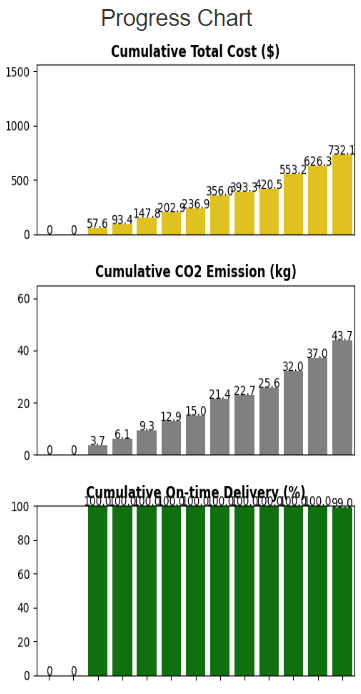